# Logistic Regression

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Exploring and cleaning data

In [3]:
df = pd.read_csv('~/Downloads/stroke data.csv')
df.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
0,1,Male,3.0,No,0,0,A,Rural,95.12,18.0,1,99.35,95.12,NaN,0
1,2,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,1,99.70,87.96,never smoked,0
2,3,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,96.35,110.89,NaN,0
3,4,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,95.52,69.04,formerly smoked,0
4,5,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,95.10,161.28,NaN,0


In [4]:
# Count missing values
df.isna().sum()

id                    0
gender                0
age                   0
married               0
hypertension          0
heart_disease         0
occupation            0
residence             0
metric_1              0
metric_2           1462
metric_3              0
metric_4              0
metric_5              0
smoking_status    13292
stroke                0
dtype: int64

In [5]:
# Replace missing values
df['smoking_status'].fillna('unknown', inplace=True)
df['smoking_status'].value_counts()

never smoked       16053
unknown            13292
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [6]:
df['metric_2'].fillna(df['metric_2'].median(), inplace=True)
df.isna().sum()

id                0
gender            0
age               0
married           0
hypertension      0
heart_disease     0
occupation        0
residence         0
metric_1          0
metric_2          0
metric_3          0
metric_4          0
metric_5          0
smoking_status    0
stroke            0
dtype: int64

In [7]:
# Column data types
df.dtypes

id                  int64
gender             object
age               float64
married            object
hypertension        int64
heart_disease       int64
occupation         object
residence          object
metric_1          float64
metric_2          float64
metric_3            int64
metric_4          float64
metric_5          float64
smoking_status     object
stroke              int64
dtype: object

In [8]:
# Get categorical columns
numeric_cols = df._get_numeric_data().columns
categorical_cols = list(set(df.columns) - set(numeric_cols))
categorical_cols

['residence', 'smoking_status', 'occupation', 'gender', 'married']

In [9]:
df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

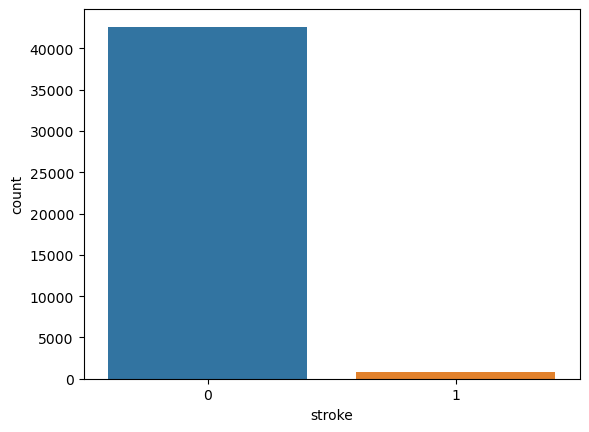

In [10]:
# Outcome 'stroke'
sns.countplot(x='stroke', data=df)
plt.show()

Our classification classes are imbalanced. There are more "no stroke" than "stroke" outcomes. This suggests that we should do oversampling of category "1" to balance the classes for building model.

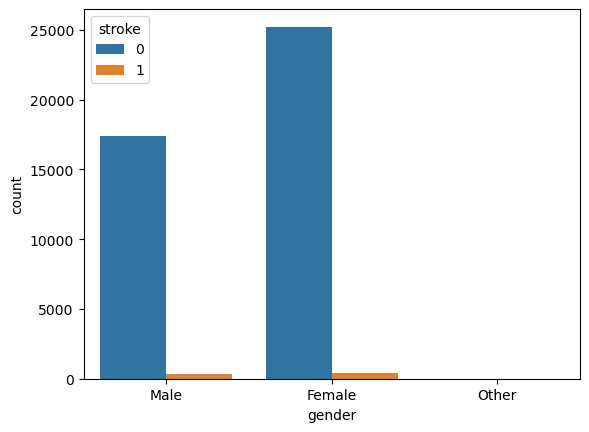

In [11]:
# Gender and stroke
sns.countplot(x='gender', hue='stroke', data=df)
plt.show()

There is not much difference in stroke rate among genders. It is hard to see if there is any difference in stroke rate among each categorical variable because the dataset is imbalanced.

<AxesSubplot:xlabel='stroke', ylabel='age'>

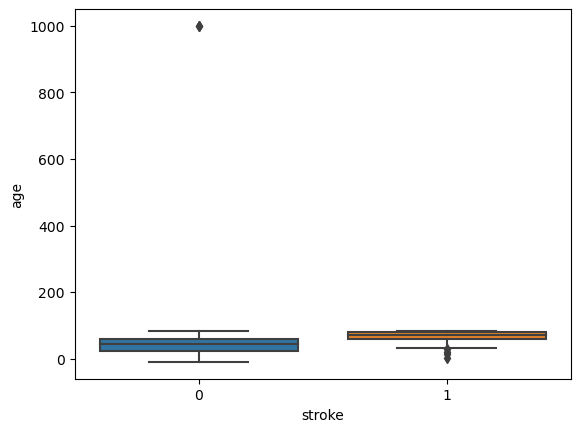

In [12]:
# Age and stroke
sns.boxplot(x='stroke', y='age', data=df)

The outlier in group 0 looks unreasonable since age cannot be almost 1000. This is probably due to mistakes in data entry.

In [13]:
# Number of rows having age > 100
sum(df['age'] > 100)

2

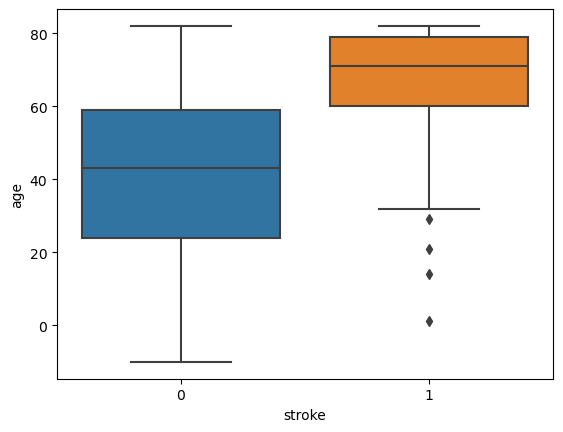

In [14]:
df = df.drop(df[df['age'] > 100].index)
sns.boxplot(x='stroke', y='age', data=df)
plt.show()

People over 60 years old are more likely to have stroke than younger age groups.

In [15]:
# Create dummy variables
df = pd.get_dummies(df)
df.head()

,id,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5,stroke,...,occupation_B,occupation_C,occupation_D,occupation_E,residence_Rural,residence_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_unknown
0,1,3.0,0,0,95.12,18.0,1,99.35,95.12,0,...,0,0,0,0,1,0,0,0,0,1
1,2,58.0,1,0,87.96,39.2,1,99.70,87.96,0,...,1,0,0,0,0,1,0,1,0,0
2,3,8.0,0,0,110.89,17.6,0,96.35,110.89,0,...,1,0,0,0,0,1,0,0,0,1
3,4,70.0,0,0,69.04,35.9,0,95.52,69.04,0,...,1,0,0,0,1,0,1,0,0,0
4,5,14.0,0,0,161.28,19.1,1,95.10,161.28,0,...,0,1,0,0,1,0,0,0,0,1


In [16]:
# Replace space with underscore in column names
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'metric_1', 'metric_2',
       'metric_3', 'metric_4', 'metric_5', 'stroke', 'gender_Female',
       'gender_Male', 'gender_Other', 'married_No', 'married_Yes',
       'occupation_A', 'occupation_B', 'occupation_C', 'occupation_D',
       'occupation_E', 'residence_Rural', 'residence_Urban',
       'smoking_status_formerly_smoked', 'smoking_status_never_smoked',
       'smoking_status_smokes', 'smoking_status_unknown'],
      dtype='object')

## Preparing data for analysis

In [17]:
# Oversampling with SMOTE
X = df.loc[:, df.columns != 'stroke']
y = df.loc[:, df.columns == 'stroke']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_X, os_y = os.fit_resample(X_train, y_train)
os_X = pd.DataFrame(data=os_X, columns=columns)
os_y = pd.DataFrame(data=os_y, columns=['stroke'])

print("Length of oversampled data:", len(os_X))
print("Number of no stroke in oversampled data:", len(os_y[os_y['stroke']==0]))
print("Number of stroke in oversampled data:", len(os_y[os_y['stroke']==1]))
print("Proportion of no stroke data in oversampled data:", len(os_y[os_y['stroke']==0])/len(os_X))
print("Proportion of stroke data in oversampled data:", len(os_y[os_y['stroke']==1])/len(os_X))

Length of oversampled data: 59610
Number of no stroke in oversampled data: 29805
Number of stroke in oversampled data: 29805
Proportion of no stroke data in oversampled data: 0.5
Proportion of stroke data in oversampled data: 0.5


In [18]:
# Recursive feature elimination (RFE)
lr = LogisticRegression()
rfe = RFE(lr)
rfe = rfe.fit(X, y)

In [19]:
# Helpful columns
X.columns[rfe.get_support()]

Index(['age', 'hypertension', 'heart_disease', 'metric_3', 'metric_4',
       'gender_Female', 'married_Yes', 'occupation_B', 'occupation_E',
       'smoking_status_never_smoked', 'smoking_status_smokes',
       'smoking_status_unknown'],
      dtype='object')

In [20]:
# Select appropriate columns
X = os_X.loc[:, rfe.get_support()]
y = os_y['stroke']

## Building model

In [21]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.278074
         Iterations 8
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.599     
Dependent Variable:      stroke              AIC:                 33175.9716
Date:                    2023-04-09 14:44    BIC:                 33283.9186
No. Observations:        59610               Log-Likelihood:      -16576.   
Df Model:                11                  LL-Null:             -41319.   
Df Residuals:            59598               LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          8.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
age  

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [23]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


## Analyzing model

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7725 1160]
 [ 826 8172]]


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8885
           1       0.88      0.91      0.89      8998

    accuracy                           0.89     17883
   macro avg       0.89      0.89      0.89     17883
weighted avg       0.89      0.89      0.89     17883



Our logistic model has an accuracy rate of 89%, which is pretty good considering the amount of preparing work we did.